In [ ]:
%load_ext autoreload

In [ ]:
import asyncio
import operator
import os
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Annotated, Literal, TypedDict

import dspy
from dspy import ChainOfThought, InputField, OutputField, Predict, Signature
from IPython.display import Image, Markdown, display
from langchain.tools import tool
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_tavily import TavilySearch
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from config import config
from data_processing import (
    load_and_process_csv,
    load_documents_from_csv,
    split_documents,
)
from embeddings import initialize_embeddings
from evaluation import (
    RAGEvaluator,
    evaluate_rag_pipeline,
    generate_test_dataset,
)
from formatting import format_messages
from prompts import scratchpad_prompt
from rag_chain import RAGOutput
from retrieval import build_retriever
from retrieval_formatter import RetrieverReportGenerator
from source_formatter import SourceFormatter
from utils import print_separator, setup_environment

In [ ]:
# from pubmed_scraper import PubMedScraper

# scraper = PubMedScraper(email = "olandechris@gmail.com")

# df = scraper.search_with_llm(query = "find me 50 papers about covid 19 from 2019 to 2025 by anthony fauci")

In [ ]:
def prepare_data(input_csv: str, output_csv: str | Path | None = None) -> Path:
    """
    Prepare and process the input data.

    Args:
        input_csv: Path to input CSV file
        output_csv: Path to save processed CSV (optional)

    Returns:
        Path to the processed CSV file
    """
    print_separator("DATA PREPARATION")
    if output_csv is None:
        output_csv = Path(config.paths.data_dir) / "tests.csv"

    # Load and process CSV
    print(f"Loading data from {input_csv}")
    df = load_and_process_csv(input_csv, output_csv)

    return Path(output_csv)

In [ ]:
def build_rag_system(csv_path: str):
    """
    Build the complete RAG system.

    Args:
        csv_path: Path to processed CSV file

    Returns:
        Tuple of (rag_chain, splitted_documents, embeddings)
    """
    print_separator("BUILDING RAG SYSTEM")
    print("Initializing Embeddings ...")

    embeddings = initialize_embeddings(
        model_name=config.model.embedding_model,
        cache_dir=config.model.embedding_cache_dir,
    )

    # Load and split the documents
    print("Loading documents...")
    documents = load_documents_from_csv(csv_path)

    print("Splitting documents...")
    splitted_documents = split_documents(documents, embeddings)
    print(f"Created {len(splitted_documents)} document chunks")

    # Build Retriever
    print("Building retriever")
    retriever = build_retriever(splitted_documents, embeddings, config.retriever)

    # Initialize RAG Chain
    print("Initializing RAG Chain ...")

    # Initialize RAG chain
    print("Initializing RAG chain...")
    rag_chain = RAGOutput(
        prompt_name="rlm/rag-prompt:latest",
        retriever=retriever,
        llm_model=config.model.deepseek_model,
    )
    rag_chain.create_chain()

    print("RAG system built successfully")
    return rag_chain, splitted_documents, embeddings

In [ ]:
def run_evaluation(
    rag_chain: RAGOutput,
    test_dataset_path: str | Path | None = None,
    results_path: str | Path | None = None,
):
    """
    Run evaluation on the RAG system.

    Args:
        rag_chain: Configured RAG chain
        test_dataset_path: Path to test dataset (optional)
        results_path: Path to save results (optional)
    """
    print_separator("EVALUATION")

    if test_dataset_path is None:
        test_dataset_path = config.paths.rag_eval_dir / "generated_testset.csv"

    if results_path is None:
        results_path = config.paths.rag_eval_dir / "results_deepseek_fastembed.csv"

    # Run evaluation
    results = evaluate_rag_pipeline(
        rag_chain=rag_chain,
        input_csv_path=str(test_dataset_path),
        output_csv_path=str(results_path),
        question_column="user_input",
    )

    print(f"Evaluation complete. Results shape: {results.shape}")
    return results

In [ ]:
def generate_synthetic_testset(
    splitted_documents, embeddings, llm, testset_size: int = 10
):
    """
    Generate synthetic test dataset using RAGAS.

    Args:
        splitted_documents: Split documents
        embeddings: Embeddings model
        llm: Language model
        testset_size: Number of test samples

    Returns:
        Generated test dataset as DataFrame
    """
    print_separator("GENERATING TEST DATASET")

    output_path = config.paths.rag_eval_dir / "generated_testset.csv"

    dataset = generate_test_dataset(
        documents=splitted_documents,
        embeddings=embeddings,
        llm=llm,
        testset_size=testset_size,
        output_path=str(output_path),
    )

    print(f"Test dataset generated with {len(dataset)} samples")
    return dataset

In [ ]:
def run_full_evaluation(embeddings):
    """
    Run comprehensive evaluation using RAGEvaluator.

    Args:
        embeddings: Embeddings model to use for evaluation

    Returns:
        Dictionary of evaluation results for all model pairs
    """
    print_separator("COMPREHENSIVE EVALUATION")

    # Initialize evaluator
    evaluator = RAGEvaluator(
        max_workers=1,
        timeout=180,
        generative_models=["deepseek-chat"],
        embedding_models=["fastembed"],
    )

    # Run evaluation for all model pairs
    results = evaluator.evaluate_all_models(
        evaluation_embeddings=embeddings, results_dir=str(config.paths.rag_eval_dir)
    )

    # Print summary
    print_separator("EVALUATION SUMMARY")
    for model_pair, df in results.items():
        print(f"\n{model_pair}:")
        print(f"  Shape: {df.shape}")
        if len(df) > 0:
            metric_cols = [
                col
                for col in df.columns
                if col
                not in ["user_input", "reference", "response", "retrieved_contexts"]
            ]
            if metric_cols:
                print(f"  Metrics: {', '.join(metric_cols)}")
                for col in metric_cols:
                    if df[col].dtype in ["float64", "int64"]:
                        print(f"    {col}: {df[col].mean():.4f} (avg)")

    return results

# Program Entry

In [ ]:
# Setup environment
setup_environment()

# Initialize configuration
print_separator("INITIALIZING")
print(f"Data directory: {config.paths.data_dir}")
print(f"RAG evaluation directory: {config.paths.rag_eval_dir}")

llm = config.initialize_llm()
dspy_lm = config.initialize_dspy()
# Prepare data
csv_path = prepare_data("data/gaza_war_impact_children.csv")

# Build RAG system
rag_chain, splitted_documents, embeddings = build_rag_system(str(csv_path))

# Generate test dataset
# generate_synthetic_testset(splitted_documents, embeddings, llm, testset_size=10)

# Run evaluation
# results = run_evaluation(rag_chain)

# eval_results = run_full_evaluation(embeddings)


================================= INITIALIZING =================================

Data directory: data
RAG evaluation directory: RAGEvaluation

=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv

============================= BUILDING RAG SYSTEM =============================

Initializing Embeddings ...
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index
Initializing RAG Chain ...
Initializing RAG chain...
RAG system built successfully


# Iteration II

In [ ]:
csv_path = prepare_data("data/gaza_war_impact_children.csv")
#  Load and split the documents
print("Loading documents...")
documents = load_documents_from_csv(csv_path)

print("Splitting documents...")
splitted_documents = split_documents(documents, embeddings)
print(f"Created {len(splitted_documents)} document chunks")

# Build Retriever
print("Building retriever")
retriever = build_retriever(splitted_documents, embeddings, config.retriever)


=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index


In [ ]:
def deduplicate_documents(documents: list[list[Document]]):
    seen = set()
    unique_docs = []

    for doc_list in documents:
        for doc in doc_list:
            if doc.page_content not in seen:
                seen.add(doc.page_content)
                unique_docs.append(doc)

    return unique_docs

In [ ]:
class MultiQueryGenerator(Signature):
    """
    Generate multiple semantically diverse versions of a query to improve retrieval.

    Purpose:
        - Rephrase the input query into several natural language variants
        - Maintain the original meaning while exploring different semantic angles
        - Optimize for both vector-based and keyword-based retrieval systems

    Guidelines:
        - Ensure queries are diverse (avoid redundancy)
        - Keep phrasing natural and conversational
        - Highlight key concepts most relevant to the original question
        - Do not change the query’s core intent

    Example:
        Input: "Impact of Gaza war on children"
        Output:
            - "Effects of Gaza conflict on child health and education"
            - "Psychological trauma among Palestinian youth in Gaza"
            - "Humanitarian impact of war on Gaza’s children"
    """

    question = InputField(
        desc="Original user query to expand into multiple rephrased variants"
    )
    num_queries: int = InputField(
        desc="Number of distinct queries to generate (recommended 3–5)"
    )

    search_queries: list[str] = OutputField(
        desc="List of semantically diverse queries that preserve the original intent"
    )

In [ ]:
query_optimizer = ChainOfThought(MultiQueryGenerator)
response = query_optimizer(
    question="Kurt Cobain is the best grunge artist ever", num_queries=3
)
response.search_queries

['Kurt Cobain influence and legacy in grunge music',
 'Why is Kurt Cobain considered the top grunge artist',
 "Kurt Cobain's impact compared to other grunge musicians"]

In [ ]:
dspy_lm.inspect_history()





[2025-10-13T13:10:43.062960]

System message:

Your input fields are:
1. `question` (str): Original user query to expand into multiple rephrased variants
2. `num_queries` (int): Number of distinct queries to generate (recommended 3–5)
Your output fields are:
1. `reasoning` (str): 
2. `search_queries` (list[str]): List of semantically diverse queries that preserve the original intent
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## num_queries ## ]]
{num_queries}

[[ ## reasoning ## ]]
{reasoning}

[[ ## search_queries ## ]]
{search_queries}        # note: the value you produce must adhere to the JSON schema: {"type": "array", "items": {"type": "string"}}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Generate multiple semantically diverse versions of a query to improve retrieval.
        
        Purpose:
            - Rephrase the input query into several natu

In [ ]:
@traceable(name="Multiquery Generator")
def generate_queries(question: str, num_queries: int = 2):
    if not question.strip():
        logger.error("Empty query provided")
        return [question]

    try:
        query_optimizer = Predict(MultiQueryGenerator)
        return query_optimizer(
            question=question, num_queries=num_queries
        ).search_queries
    except Exception as e:
        logger.error(f"An error occurred during query generation: {str(e)}")
        return [question]


test_question = "Impact of the Gaza war on children"
generate_queries(question=test_question)

["Effects of the Gaza conflict on children's health and education",
 "Psychological and humanitarian impact of war on Gaza's youth"]

In [ ]:
@tool
async def retriever_tool(search_query: str):
    """
    Retrieves pubmed data using the provided query and generates a report in markdown format.
    """
    report_gen = RetrieverReportGenerator()
    search_queries = generate_queries(question=search_query)

    tasks = [retriever.ainvoke(q) for q in search_queries]
    results = await asyncio.gather(*tasks)

    valid_results = [r for r in results if r]

    if not valid_results:
        return "No relevant documents found for the given query"

    deduplicated_results = deduplicate_documents(valid_results)
    report = report_gen.create_report(deduplicated_results)
    return report["markdown"]

In [ ]:
report = asyncio.run(
    retriever_tool.ainvoke("Impact of the Gaza war on children mental wellbeing")
)

In [ ]:
async def tavily_search_async(
    search_query: str,
    max_results: int = 2,
    num_queries: int = 2,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    if not search_query.strip():
        logger.warning("The search query cannot be an empty string")

    try:
        tavily_search = TavilySearch(
            max_resutls=max_results,
            num_queries=num_queries,
            include_raw_content=include_raw_content,
            topic=topic,
        )
        # Generate multiple queries from the single query
        try:
            search_queries = generate_queries(
                question=search_query, num_queries=num_queries
            )
        except Exception as e:
            logger.warning(
                f"Failed to generate query variations, using original query: {str(e)}"
            )
            search_queries = [search_query]
        # Execute the searches concurrently
        tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
        results = await asyncio.gather(*tasks)
        return results
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []


@tool
async def web_search(
    search_query: str,
    max_results: int = 1,
    include_raw_content: bool = True,
    markdown_output: bool = False,
):
    """
    Search the web for the given search queries.
    """
    try:
        formatter = SourceFormatter(markdown_output=markdown_output)
        search_response = await tavily_search_async(
            search_query,
            max_results=max_results,
            include_raw_content=include_raw_content,
        )
        deduplicated_response = formatter.deduplicate_and_format_sources(
            search_response
        )
        return deduplicated_response
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []

In [ ]:
web_response = asyncio.run(
    web_search.ainvoke("Impact of the Gaza war on children's mental wellbeing")
)

2025-10-13 13:10:57 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-10-13 13:10:57 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 8 unique sources


# Offload the context

In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""

    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes",
    )


class WriteToScratchpad(BaseModel):
    """Write or append to the scratchpad for context retention"""

    notes: str = Field(description="The notes to write to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites the existing notes",
    )


class ReadFromScratchpad(BaseModel):
    """Read context from scratchpad"""

    query: str = Field(
        default="all",
        description="What to look for in the scratchpad. Use 'all' for everything",
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context"""

    confirm: bool = Field(
        description="Must be True to confirm the clearing of the scratchpad"
    )

In [ ]:
tools = [
    WriteToScratchpad,
    ReadFromScratchpad,
    ClearScratchpad,
    web_search,
    retriever_tool,
]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Create tool registry for easier lookup (map name -> tool object)
tool_by_name = {
    (tool.name if hasattr(tool, "name") else tool.__name__): tool for tool in tools
}

In [ ]:
def llm_call(state: ScratchpadState):
    system_message_content = scratchpad_prompt
    if state.scratchpad:
        system_message_content += f"\n\nCURRENT SCRATCHPAD:\n{state.scratchpad}"

    messages = [SystemMessage(system_message_content)] + state.messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [ ]:
def _save_scratchpad(content: str, filepath: str):
    """Persist scratchpad content to markdown file."""
    base_dir = Path("scratchpads")
    base_dir.mkdir(parents=True, exist_ok=True)
    full_path = base_dir / filepath
    full_path.write_text(content, encoding="utf-8")


def _handle_write(tool_args, state, tool_call_id):
    notes = tool_args.get("notes", "")
    mode = tool_args.get("mode", "append")

    if mode == "replace":
        new_content = notes
    else:
        separator = "\n\n" if state.scratchpad else ""
        new_content = f"{state.scratchpad}{separator}{notes}"

    return new_content, ToolMessage(
        content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call_id
    )


def _handle_read(tool_args, state, tool_call_id):
    scratchpad_content = state.scratchpad or "Scratchpad is empty."
    query = tool_args.get("query", "all")

    if query != "all":
        content = f"Scratchpad contents (query: '{query}'): \n\n{scratchpad_content}"
    else:
        content = f"Scratchpad contents: \n\n{scratchpad_content}"

    return ToolMessage(content=content, tool_call_id=tool_call_id)


def _handle_clear(tool_args, tool_call_id):
    confirm = tool_args.get("confirm", False)

    if confirm:
        return "", ToolMessage(
            content="Scratchpad cleared successfully.",
            tool_call_id=tool_call_id,
        )
    return None, ToolMessage(
        content="Scratchpad clear cancelled (confirm=False).",
        tool_call_id=tool_call_id,
    )


async def _handle_external(tool_name, tool_args, tool_call_id):
    tool = tool_by_name[tool_name]
    observation = await tool.ainvoke(tool_args)
    return ToolMessage(content=str(observation), tool_call_id=tool_call_id)


async def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and update state accordingly."""
    last_message = state.messages[-1]
    if not getattr(last_message, "tool_calls", None):
        return {"messages": []}

    result_messages = []
    scratchpad_update = None

    for tool_call in last_message.tool_calls:
        tool_name, tool_args, tool_call_id = (
            tool_call["name"],
            tool_call["args"],
            tool_call["id"],
        )

        if tool_name == "WriteToScratchpad":
            scratchpad_update, msg = _handle_write(tool_args, state, tool_call_id)
            result_messages.append(msg)  # Keep scratchpad confirmations
        elif tool_name == "ReadFromScratchpad":
            msg = _handle_read(tool_args, state, tool_call_id)
            result_messages.append(msg)  # Keep read responses
        elif tool_name == "ClearScratchpad":
            scratchpad_update, msg = _handle_clear(tool_args, tool_call_id)
            result_messages.append(msg)  # Keep clear confirmations
        else:
            # Execute tool but don't add its response to messages
            msg = await _handle_external(tool_name, tool_args, tool_call_id)
            # Create a lightweight confirmation instead of full content
            lightweight_msg = ToolMessage(
                content=f"Tool {tool_name} executed successfully. Results saved to context.",
                tool_call_id=tool_call_id,
            )
            result_messages.append(lightweight_msg)

    update = {"messages": result_messages}
    if scratchpad_update is not None:
        update["scratchpad"] = scratchpad_update
        filepath = getattr(state, "scratchpad_file", None)
        if filepath is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = f"scratchpad_{timestamp}.md"
            update["scratchpad_file"] = filepath
        _save_scratchpad(scratchpad_update, filepath)

    return update


def tools_condition(state: ScratchpadState):
    """Determine whether to call tools or end the agent loop."""
    last_message = state.messages[-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

In [ ]:
async def run_agent_example():
    # Initial state
    initial_state = ScratchpadState(
        messages=[
            HumanMessage(
                content="What are the impacts of the Israel-Gaza war on children's mental well-being?"
            )
        ],
        scratchpad="",
    )

    # Run the agent
    result = await graph.ainvoke(initial_state)

    format_messages(result["messages"])


# asyncio.run(run_agent_example())

# Report Generation

In [ ]:
class Section(BaseModel):
    name: str = Field(
        description="Medical research section title reflecting PubMed study focus (e.g., 'Pediatric Mental Health Outcomes', 'Conflict-Related Injuries', 'Public Health Impact')"
    )
    description: str = Field(
        description="Medical research context explaining what peer-reviewed evidence this section will analyze"
    )
    research: bool = Field(
        description="True if requires current PubMed literature search, systematic reviews, or specific clinical studies. False only for background/methodology sections"
    )
    content: str = Field(
        description="Specific medical evidence requirements: study types needed (RCTs, cohort studies, case reports), population focus, clinical outcomes, or epidemiological data"
    )

    audience_complexity: str = Field(
        description="Medical evidence level: 'clinical_practitioners', 'public_health_officials', 'medical_researchers', or 'policy_makers'",
        default="clinical_practitioners",
    )

    estimated_length: str = Field(
        description="Evidence depth: 'brief', 'standard', or 'comprehensive'",
        default="standard",
    )

    dependencies: list[str] = Field(
        description="Sections that must precede this one for proper medical context",
        default_factory=list,
    )

    success_criteria: str = Field(
        description="Specific medical research outcome or evidence synthesis goal",
        default="",
    )


class Sections(BaseModel):
    sections: list[Section] = Field(
        description="Medical literature review sections following systematic review or evidence synthesis structure"
    )

    total_estimated_length: str = Field(
        description="Medical review scope: 'rapid_review', 'systematic_review', or 'comprehensive_meta_analysis'",
        default="systematic_review",
    )

    primary_audience: str = Field(
        description="Target medical audience: 'clinicians', 'public_health_officials', 'researchers', 'humanitarian_workers', or 'policy_makers'",
        default="clinicians",
    )

    narrative_strategy: str = Field(
        description="Medical research approach: 'systematic_review', 'scoping_review', 'epidemiological_analysis', or 'clinical_evidence_synthesis'",
        default="systematic_review",
    )

In [ ]:
class ReportPlanner(dspy.Signature):
    """Generate a structured, evidence-based plan for medical literature reviews.

    Creates a detailed research plan broken into logical sections, each specifying:
    - Research objectives and clinical questions
    - Evidence requirements and quality criteria
    - Data sources and search strategies
    - Analysis methods appropriate for the medical context

    Outputs conform to a predefined JSON schema for downstream processing.
    """

    topic: str = InputField(
        desc="The central medical or public health topic for literature review"
    )

    context: str = InputField(
        desc="Comprehensive requirements including: target population, clinical aspects to cover, public health dimensions, intended audience, data quality constraints (recency, source types), and scope (immediate vs long-term impacts)"
    )

    report_organization: str = InputField(
        desc="Detailed report structure specification including: section breakdown (intro, body, conclusion), research intensity per section, content requirements (concepts, case studies, trends), structured elements needed (tables, frameworks), and research standards (source recency, authority, diversity)"
    )

    plan: Sections = OutputField(
        desc="JSON-structured research plan with 4-6 main body sections, each containing: section title, research objectives, specific search queries, required source types (peer-reviewed, humanitarian reports), evidence quality criteria, and analytical approach"
    )

In [ ]:
context = """This report should examine the multifaceted effects of war on children in Gaza. It must integrate clinical aspects (physical injuries, malnutrition, infectious diseases, mental health disorders such as PTSD and anxiety) with broader public health perspectives (displacement, education disruption, loss of caregivers, and access to healthcare and humanitarian aid). The audience includes pediatricians, humanitarian organizations, policymakers, and global health researchers, requiring evidence-based insights that balance medical detail with humanitarian urgency. Constraints: prioritize high-quality, recent (≤3 years) data from UNICEF, WHO, UNRWA, MSF, and peer-reviewed public health/medical sources. The report should highlight not only immediate health impacts but also long-term developmental consequences, systemic barriers to care, and actionable strategies for local and international stakeholders."""


report_organization = """The report structure should provide a comprehensive breakdown of the user-provided topic:

    ## 1. Introduction (no research needed)
       - Brief overview and scope of the topic
       - Current relevance and importance

    ## 2. Main Body Sections (research-intensive):
       Each section should focus on a distinct sub-topic with:
       - Key concepts, definitions, and current data/statistics
       - Real-world examples, case studies, or expert insights
       - Trends, challenges, or emerging developments
       - Consider: analytical, comparative, impact, solution, or future outlook angles

    ## 3. Conclusion & Recommendations
       - Include ONE structured element: comparative table, ranked list, or synthesis framework
       - Clear, actionable conclusions based on research
       - Future implications

    ## Research Standards:
    - Prioritize recent sources (last 2-3 years)
    - Include diverse, authoritative perspectives
    - Balance academic research with practical applications
    - Aim for 4-6 substantive main body sections"""

In [ ]:
structured_planner = Predict(ReportPlanner)
topic = test_question
result = structured_planner(
    topic=topic, context=context, report_organization=report_organization
)
result.plan.sections

[Section(name='Introduction', description='Overview of the Gaza conflict context and its specific impact on pediatric populations, establishing the scope and significance of the medical literature review', research=False, content='Background on Gaza conflict timeline, demographic profile of affected children, and rationale for focusing on pediatric health outcomes in conflict settings', audience_complexity='clinical_practitioners', estimated_length='brief', dependencies=[], success_criteria='Clear establishment of context and rationale for systematic review of pediatric war impacts'),
 Section(name='Physical Trauma and Injury Patterns', description='Analysis of conflict-related physical injuries including blast injuries, gunshot wounds, burns, and their clinical management in resource-constrained settings', research=True, content='Requires peer-reviewed studies on pediatric trauma epidemiology, injury mechanisms, surgical outcomes, mortality rates, and rehabilitation challenges from re

In [ ]:
@dataclass(frozen=True, kw_only=True)
class ReportConfig:
    """Configurable fields for the medical report pipeline."""

    context: str = context
    report_organization: str = report_organization

    @classmethod
    def from_runnable_config(
        cls, config: RunnableConfig | None = None
    ) -> "ReportConfig":
        """Create ReportConfig from RunnableConfig."""
        cfg = config.get("configurable", {}) if config else {}

        return cls(
            context=os.environ.get("CONTEXT") or cfg.get("context") or context,
            report_organization=os.environ.get("REPORT_ORGANIZATION")
            or cfg.get("report_organization")
            or report_organization,
        )

In [ ]:
class ReportStateInput(TypedDict):
    topic: str


class ReportStateOutput(TypedDict):
    final_report: str


class ReportState(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    completed_sections_context: (
        str  # String of any completed sections from research to write final sections
    )
    final_report: str  # Final report

In [ ]:
def generate_plan(state: ReportState, config: RunnableConfig):
    report_cfg = ReportConfig.from_runnable_config(config)

    topic = state.get("topic")
    context = report_cfg.context
    report_organization = report_cfg.report_organization

    # Generate the plan
    planner = Predict(ReportPlanner)
    result = planner(
        topic=topic, context=context, report_organization=report_organization
    )
    return {"sections": result.plan.sections}

In [ ]:
class SectionState(MessagesState):
    section: Section
    research_context: str
    completed_sections_context: (
        str  # Narrative flow / dependency text from earlier sections
    )
    completed_sections: list[
        Section
    ]  # Final key we duplicate in the outer state before sending it to the Send() API

    scratchpad: str = ""
    scratchpad_file: str = ""


class SectionStateOutput(TypedDict):
    completed_sections: list[Section]

In [ ]:
tools = [retriever_tool, web_search]

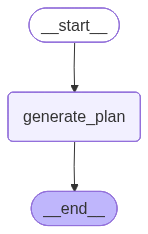

In [ ]:
graph_builder = StateGraph(ReportState)
graph_builder.add_node("generate_plan", generate_plan)
graph_builder.set_entry_point("generate_plan")
graph = graph_builder.compile()
graph

In [ ]:
state = {"topic": test_question}

config = RunnableConfig(
    configurable={
        "context": context,
        "report_organization": report_organization,
    }
)

# Run the graph
planner_result = graph.invoke(state, config=config)

print(planner_result["sections"][3])

name='Mental Health and Psychosocial Impacts' description='Comprehensive review of PTSD, anxiety, depression, and developmental trauma disorders among Gaza children, including protective factors and resilience' research=True content='Meta-analysis of mental health prevalence studies, trauma exposure assessments, intervention trials, and longitudinal developmental outcomes from recent conflict periods' audience_complexity='medical_researchers' estimated_length='comprehensive' dependencies=['Introduction'] success_criteria='Synthesis of mental health epidemiology, risk factors, and evidence-based intervention approaches'


# Write sections, but with context offloading

In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""

    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes",
    )


class WriteToScratchpad(BaseModel):
    """Write or append to the scratchpad for context retention"""

    notes: str = Field(description="The notes to write to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites the existing notes",
    )


class ReadFromScratchpad(BaseModel):
    """Read context from scratchpad"""

    query: str = Field(
        default="all",
        description="What to look for in the scratchpad. Use 'all' for everything",
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context"""

    confirm: bool = Field(
        description="Must be True to confirm the clearing of the scratchpad"
    )

In [ ]:
tools = [
    WriteToScratchpad,
    ReadFromScratchpad,
    ClearScratchpad,
    web_search,
    retriever_tool,
]
llm_with_tools = llm.bind_tools(tools)

# Create tool registry for easier lookup (map name -> tool object)
tool_by_name = {
    (tool.name if hasattr(tool, "name") else tool.__name__): tool for tool in tools
}

In [ ]:
llm_with_tools = llm.bind_tools(tools)
section_writer_prompt = """You are an expert technical report section writer with expertise in:
- Technical and medical research translation into clear, actionable text
- Evidence validation, precision reporting, and authoritative sourcing
- Audience-tailored writing with calibrated complexity levels
- Structural discipline for coherence, density, and clarity

CORE OBJECTIVE:
Transform a Section model specification into a rigorously detailed report section that delivers maximum informational value while aligning with the section's strategic purpose, audience complexity, and success criteria.

PROCESSING STRATEGY:
1. INTERPRET: Analyze the section name, description, and content requirements
2. RESEARCH: Use available tools (PubMed search, web search) to gather evidence
   - IMPORTANT: Use WriteToScratchpad to save ONLY key findings, statistics, quotes, and URLs
   - Extract and summarize - do NOT save full articles
   - Keep notes concise and focused on what's needed for the section
3. CALIBRATE: Adapt complexity level based on audience requirements
4. PRIORITIZE: Lead with the single most impactful insight
   - Use ReadFromScratchpad to review your condensed notes
5. DEVELOP: Build content from scratchpad notes matching estimated length
6. VALIDATE: Ensure content meets success criteria with authoritative sourcing


SCRATCHPAD WORKFLOW:

* During research: Use `WriteToScratchpad` to record **key factual information**, not summaries.
* Preserve **exact details** — numbers, statistics, percentages, dates, and direct quotes.
* Include **full URLs** for every claim or data point.
* Capture **contextual relevance** — briefly note *why* each data point is important for the section.
* Exclude **methodology details**, author information, and unrelated background content.
* For significant findings, use **verbatim quotes** in the format: `"exact text here"` (Source).

TOOL USAGE:
- Use retriever_tool for peer-reviewed medical literature and research findings from pubmed
- Use web_search for current news, statistics, or supplementary information
- Always prioritize PubMed over general web search for medical/scientific content
- After each search, extract key points to scratchpad immediately

CONTENT REQUIREMENTS:
- Section Title: Use `##` with section name as heading in Markdown
- Opening: Bold statement aligned with section purpose
- Length: Match estimated_length (brief: 75-100 words, standard: 150-200, comprehensive: 250-350)
- Complexity: Match audience_complexity (introductory: minimal jargon, intermediate: balanced depth, advanced: expert-level)
- Citations: Include exact URLs from retrieved sources
- Sources section formatted as:
  ### Sources
  Title : URL

OUTPUT QUALITY:
- Strategic alignment with section description
- Technical precision with exact figures and benchmarks
- Real-world examples when beneficial
- Smooth logical flow
- Verifiable citations with URLs from actual retrieved sources"""

initial_research_prompt = """Write the following section for a technical report:

**Section Name:** {name}
**Description:** {description}
**Requirements:** {content}
**Audience Complexity:** {audience_complexity}
**Estimated Length:** {estimated_length}
**Dependencies:** {dependencies}
**Success Criteria:** {success_criteria}

You MUST search for current, evidence-based information relevant to this section. Focus on the key issues highlighted in the description and content. Use your available tools (PubMed, web search, etc.) to gather peer-reviewed, authoritative, or current data. Summarize findings concisely and accurately, preparing the information to be used in drafting the section content."""

In [ ]:
def write_sections(state: SectionState):
    messages = state.get("messages", [])
    section = state["section"]
    scratchpad = state.get("scratchpad", "")

    # tool_messages = [msg for msg in messages if isinstance(msg, ToolMessage)]

    if not messages:
        prompt = initial_research_prompt.format(
            name=section.name,
            description=section.description,
            content=section.content,
            audience_complexity=section.audience_complexity,
            estimated_length=section.estimated_length,
            dependencies=section.dependencies,
            success_criteria=section.success_criteria,
        )

        messages = [
            SystemMessage(content=section_writer_prompt),
            HumanMessage(content=prompt),
        ]

    elif scratchpad:
        scratchpad_prompt = f"""You have completed your research. Review your scratchpad notes below and write the final section:

        Your scratchpad notes:
        {scratchpad}

        Now write the final section content based on these notes."""
        messages = [
            SystemMessage(content=section_writer_prompt),
            HumanMessage(content=scratchpad_prompt),
        ]

    response = llm_with_tools.invoke(messages)
    if hasattr(response, "content"):
        section.content = response.content
        return {"messages": messages + [response], "completed_sections": [section]}

    return {"messages": messages + [response]}

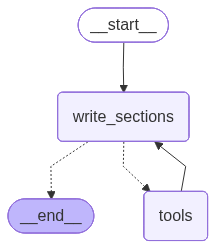

In [ ]:
section_graph = StateGraph(SectionState, output_schema=SectionStateOutput)
section_graph.add_node("write_sections", write_sections)
section_graph.add_node("tools", tool_node)
section_graph.add_conditional_edges(
    "write_sections", tools_condition, {"tools": "tools", "__end__": END}
)
section_graph.add_edge("tools", "write_sections")
section_graph.set_entry_point("write_sections")

section_builder = section_graph.compile()
display(Image(section_builder.get_graph().draw_mermaid_png()))

In [ ]:
planner_result["sections"][3]

Section(name='Mental Health and Psychosocial Impacts', description='Comprehensive review of PTSD, anxiety, depression, and developmental trauma disorders among Gaza children, including protective factors and resilience', research=True, content="## Mental Health Impact on Gaza's Children\n\n**The mental health consequences for children in Gaza represent one of the most severe documented cases of collective trauma in modern conflict zones, with overwhelming evidence of widespread psychological distress that demands urgent, specialized intervention.** Research consistently demonstrates catastrophic prevalence rates, with PTSD affecting 54-91% of Gaza's children, anxiety disorders impacting 70-85%, and depression affecting 45-70% of the pediatric population across various assessments. These staggering figures reflect the cumulative impact of repeated conflict exposures, displacement, and direct violence exposure.\n\nThe trauma exposure patterns reveal critical risk factors: children witnes

In [ ]:
section_state = SectionState(section=planner_result["sections"][3])
section_writer_result = asyncio.run(section_builder.ainvoke(section_state))

2025-10-13 13:57:15 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-10-13 13:57:15 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 10 unique sources


In [ ]:
Markdown(section_writer_result["completed_sections"][0].content)

## Psychological Impact on Children

**The psychological trauma affecting Gaza's children represents a catastrophic mental health crisis with nearly universal exposure to severe psychological distress.** Recent studies document post-traumatic stress disorder (PTSD) prevalence rates ranging from 54% to 91% among pediatric populations, while anxiety disorders affect 70-85% and depression rates span 45-70%. According to 2023 UNICEF data, a staggering 94% of children in Gaza exhibit symptoms of depression, anxiety, and grief, with 2024 assessments indicating that 9 out of 10 children show PTSD symptoms and 3 in 4 require mental health support. UNICEF's 2024 assessment concludes that "nearly every child in Gaza is now believed to be in need of mental health and psychosocial support."

The trauma burden follows a clear dose-response pattern, where children witnessing family member injury or death face 3-4 times increased PTSD risk, and cumulative trauma exposure directly correlates with symptom severity. Multiple conflict episodes throughout development lead to complex trauma disorders, with displacement and home destruction emerging as significant predictors of psychological distress. However, protective factors including strong family support reduce PTSD risk by 50%, while community cohesion and educational continuity during conflict periods demonstrate protective effects.

Intervention studies show promising outcomes despite infrastructure constraints, with school-based programs achieving 30-40% reductions in PTSD symptoms, cognitive-behavioral therapy approaches demonstrating consistent effectiveness, and parent-child interventions significantly improving family functioning. The long-term implications are profound, as untreated childhood trauma leads to persistent symptoms extending into adulthood, developmental delays, and intergenerational transmission of trauma patterns, underscoring the critical need for early intervention to prevent lifelong consequences.

### Sources
Multiple trauma studies on Gaza children mental health: PubMed database
UNICEF reports and current conflict impact assessments: https://www.unicef.org/press-releases/nearly-every-child-gaza-now-believed-be-need-mental-health-and-psychosocial-support